In [1]:
import tensorflow.keras
tensorflow.keras.__version__

'2.4.0'

# Utilizando convnets con datasets pequeños

Lo primero que tienes que hacer es descargarte el dataset de https://lara.web.cern.ch/lara/train.zip en la terminal de Jupyter y descomprimirlo en la misma carpeta donde se encuentra esta libreta. 

Para descargar otro conjunto de datos desde imagenet se puede descargar la lista con las URL a las imágenes y usar `wget -i`



## Entrenando desde 0 una convNet

Entrenar un modelo de clasificación de imágenes con muy pocos datos es una situación común en la que te encontrarás si acabas dedicándote a hacer Computer Vision en un contexto profesional. 

Tener "pocas" muestras puede significar cualquier cosa entre unos pocos cientos y unas pocas decenas de miles de imágenes. Vamos a ilustrar aqui un ejemplo práctico: vamos a centrarnos en clasificar imágenes como "perros" y "gatos".


## La relevancia del Deep Learning en problemas con pocos datos

Quizás habrás oido muchas veces que el Deep Learning solo funciona cuando se tienen grandes cantidades de datos. Esto en parte es verdad: una de las características del Deep learning es que puede encontrar características interesantes a partir del dataset de entrenamiento por si mismo, y esto a priori es más sencillo cuando se tienen muchos ejemplos disponibles, especialmente en el caso de tener datasets de input con una alta dimensionalidad, como es el caso de las imágenes.

Sin embargo, lo que constituye un dataset "grande" es relativo. Concretamente relativo al tamaño y la profundidad de la red que estamos intentando entrenar. No es posible enrenar una convnet para que resulta un problema completo con solo unas decenas de ejemplos, pero unos pocos cientos puede ser suficiente si el modelo está bien montado (entenderemos que significa bien "montado" a lo largo del curso de Deep Learning).

Como las convnets aprenden características locales, invariantes bajo translaciones, son muy eficientes en cuanto al número de imágenes necesarias para llevar a cabo problemas perceptuales. Así que entrenar una convnet desde 0 con un dataset no muy grande aún nos puede llevar a resultados razonables como veremos aqui.

Pero hay más aún: los modelos de Deep Learning son altamente "reciclables". Uno puede coger, por ejemplo, un problema de clasificación de imagen y un convertidor de voz a texto entrenado sobre un dataset muy grande y luego reutilizarlo para resolver otro problema completamente distinto solo añadiéndole pequeñas modificaciones. Más especificamente, en el caso de Computer Vision, muchos modelos pre-entrenados (normalmente entrenados en el dataset ImageNet) son hechos publicos para que uno pueda descargarlos y utilizarlos para crear potentes modelos de Computer Vision con muy pocos datos. 

Pero aqui nos vamos a limitar a correr un ejemplo sencillito. 


## Los datos

El dataset de gatos vs perros que utilizamos no es un paquete de Keras. Se publicó en Kaggle.com como parte de un problema de Computer Vision a finales de 2013, cuando todavía las ConvNets no eran tan populares. 

Las imágenes son JPGEs de resolución media. Tiene este aspecto:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

No es ninguna sorpresa que la competición de gatos vs perros de Kaggle en 2013 fuera ganada por ConvNets. Los mejores pudieron alcanzar una precisión de hasta 95%. En nuestro ejemplo vamos a quedarnos todavía lejos de esta precisión, pero durante el curso de Deep Learning hemos aprendido como acercarnos a este valor utilizando diversos métodos para mejorar el rendimiento de las redes neuronales. Hay que tener en cuenta que en este ejemplo estamos entrenando aproximadamente sobre solo el 10% de los datos que se utilizaron para el concurso. 
Después de descargar el dataset y descomprimirlo, vamos a crear un nuevo dataset que contiene tres subsets: un set de training que contiene 1000 imágenes de cada clase, un set de validación con 500 imágenes de cada clase, y finalmente un set de test con 500 imágenes de cada clase.

Aqui tenemos unas cuantas líneas de código que nos hacen este reparto automáticamente:



In [2]:
import os, shutil

In [3]:
train_cats_dir = './cats_and_dogs_small/train/cats/'
train_dogs_dir = './cats_and_dogs_small/train/dogs/'
validation_cats_dir = './cats_and_dogs_small/validation/cats/'
validation_dogs_dir = './cats_and_dogs_small/validation/dogs/'
test_cats_dir = './cats_and_dogs_small/test/cats/'
test_dogs_dir = './cats_and_dogs_small/test/dogs/'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))

print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))

print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



Así que efectivamente tenemos 2000 imágenes de entrenamiento, 1000 imágenes de validación y 1000 imágenes de test. En cada uno de estos subsets hay el mismo número de ejemplos de cada clase: esto es lo que se llama un sistema de clasificación binario balanceado, lo cual significa que nuestra precisión de clasificación será una métrica adecuada del éxito de nuestra solución.

## Construyendo nuestra red

En el anterior ejemplo hemos construido una pequeña convnet para resolver el problema de clasificar números escritos a mano usando el dataset MNIST, así que ya estamos familiarizados con la terminología que utiliza keras. Vamos a reutilizar la estructura general que teniamos en el ejemplo anterior: nuestra convnet tendra una pila de capas alternadas de `Conv2D` (con activación `relu` ) y capas  `MaxPooling2D`.

Sin embargo, como estamos tratando con imágenes mayores y un problema más complejo, vamos a crear nuestra red en consecuencia: tendrá una capa más de `Conv2D` + `MaxPooling2D`. Esto sirve para aumentar la capacidad de la red y para reducir aún más el tamaño de los mapas de características, para que no sean tan enormes cuando lleguen al paso de aplanado. Empezamos usando imágenes de input de 150x150 (una elección arbitraria), y acabaremos con mapas de características que tienen un tamaño de 7x7 antes de la capa de aplanamiento.

Es importante tener en cuenta que la profundidad de los mapas de características va creciendo progresivamente según se avanza en la red neuronales ( de 32 a 128) mientras que el tamaño de los mapas de características va disminuyendo (de 148x148 a 7x7). Este patrón lo verás en casi todas las convnets.

Como estamos atacando un problema de clasificación binaria (perro o gato), vamos a acabar la red con una única unidad (una capa densa de tamaño 1) y con una activación sigmoide. Esta unidad codificará la probabilidad de que nuestra red esté mirando a una clase o a otra.

El aspecto final del modelo debe de ser el siguiente:

![modelo_red_animales.png](https://github.com/laramaktub/MachineLearningI/blob/master/modelo_red_animales.png?raw=true)

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

2022-04-15 23:10:15.645508: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 23:10:15.645657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 23:10:15.646183: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Para el paso de compilación utilizaremos el optimizador `RMSprop`(lr=1e-4). Como nuestra red termina con una única unidad sigmoide, vamos a utilizar binary crossentropy como nuestra función de pérdida.

In [6]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

##  Preprocesado de datos

Las imágenes deben estar formateadas apropiadamente en tensores de flotantes antes de dárselas a la red. Esto es justo lo que vamos a hacer aqui. Antes de preprocesarlas las imágenes son archivos JPEG. Los pasos para poder darlos a nuestra red son a grandes rasgos:

* Leer los archivos con las imágenes.
* Decodificar el contenido del JPEG en una "parrilla" con el RGB de los pixels 
* Convertir esa "parrilla" en tensores de flotantes
* Re-escalar los valores de los pixels (enre 0 y 255) al intervalo [0, 1] ya que las redes neuronales prefieren trabajar con valores pequeños. 

Todo esto puede parecer muy complicado pero gracias a Keras nuestra vida es mucho más fácil y podemos contar con tus herramientas para ocuparse de estos pasos automaticamente. Keras tiene un módulo con herramientas para el tratamiento de imágenes, que se puede encontrar en  `keras.preprocessing.image`. En particular, contiene la clase `ImageDataGenerator` que nos permite automaticamente convertir imágenes que tengamos en el disco duro en tensores pre-procesados. Esto es justamente lo que usaremos a continuación. Para ello podemos utilizar el flow_from_directory para coger las imágenes directamente de las carpetas que generamos previamente. Le damos como entrada las carpetas donde están las imágenes de entrenamiento (o validación), el tamaño de las imágenes (target_size), tamaño del batch que vamos a usar (vamos a empezar por 20) y como solo hay dos categorías, le decimos que vamos a usar binary_crossentropy (class_mode). Al correr estos comandos obtendremos lo siguiente el número total de imágenes y cuantas clases hay.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory('./cats_and_dogs_small/train/', target_size=(150,150),batch_size=20, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('./cats_and_dogs_small/validation/', target_size=(150,150),batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Vamos a echar un vistazo a uno de estos generadores: nos lleva a un batch de 150x150 imágenes RGB (dimensiones `(20, 150, 150, 3)`) y etiquetas binarias (dimensión `(20,)`). 20 es el número de ejemplos en cada batch (lo que llamamos el tamaño del batch). El generador genera estos batches de manera indefinida: corre un bucle sin cesar por todas las imágenes que tengamos en la carpeta. Por eso tenemos que escribir `break` para romper el bucle en algún momento.


In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Ahora vamos a hacer el fit. En este caso, como lo que tenemos es un generator, utilizamos fit_generator. Vamos a correr 30 épocas y a utilizar el dataset de validación.

In [ ]:
history = model.fit_generator(train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Es una buena idea guardar el modelo después de entrenar:

In [ ]:
model.save('net_images.h5')

Ahora evalua el modelo en el dataset de test.

In [9]:
import matplotlib.pyplot as plt

def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


In [ ]:
plot_result(history)

In [24]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory('./cats_and_dogs_small/test/',
                batch_size = 20, target_size = (150,150), 
                class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator)

print(f'Fundion de conste: {test_loss}')

print(f'Precision: {test_acc}')

Prueba a optimizar la red. Para ello puedes utilizar las herramientas utilizadas en clase. Puedes probar a optimizar en términos de velocidad y de accuracy. Comenta los resultados.

Con el fin de mejorar el modelo podemos comenzar haciendo `DataAugmentation`

`DataAugmentation` permite aumentar el número de datos con copias modificadas de los datos con rotaciones, por ejemplo.

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=40, width_shift_range=0.2, 
                                   height_shift_range=0.2,shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True,)
train_generator = train_datagen.flow_from_directory('./cats_and_dogs_small/train/', target_size=(150, 150), batch_size=32,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


Para el sobreajuste introducimos una capa `Dropout`

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) #NUEVA CAPA
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=2000/32, epochs=30, 
                              validation_data=validation_generator, validation_steps=50)

Epoch 1/30
62/62 [==============================] - 25s 400ms/step - loss: 0.6803 - acc: 0.5630 - val_loss: 0.6670 - val_acc: 0.5650
Epoch 2/30
62/62 [==============================] - 26s 409ms/step - loss: 0.6723 - acc: 0.5815 - val_loss: 0.6538 - val_acc: 0.5980
Epoch 3/30
62/62 [==============================] - 25s 404ms/step - loss: 0.6623 - acc: 0.6035 - val_loss: 0.6628 - val_acc: 0.5870
Epoch 4/30
62/62 [==============================] - 25s 395ms/step - loss: 0.6474 - acc: 0.6290 - val_loss: 0.6638 - val_acc: 0.5910
Epoch 5/30
62/62 [==============================] - 25s 397ms/step - loss: 0.6383 - acc: 0.6455 - val_loss: 0.6236 - val_acc: 0.6380
Epoch 6/30
62/62 [==============================] - 25s 399ms/step - loss: 0.6286 - acc: 0.6400 - val_loss: 0.6212 - val_acc: 0.6360
Epoch 7/30
62/62 [==============================] - 25s 405ms/step - loss: 0.6178 - acc: 0.6430 - val_loss: 0.5997 - val_acc: 0.6590
Epoch 8/30
62/62 [==============================] - 25s 401ms/step - 

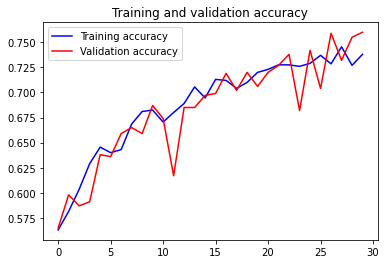

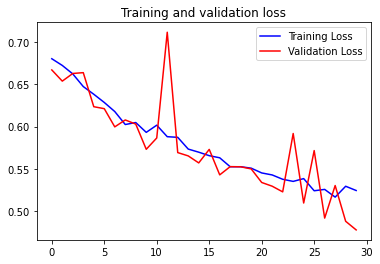

In [17]:
plot_result(history)

Como caso final podemos utilizar `Transfer Learning` que consiste en tomar caracteristicas aprendidas en un problema aprovechandolas en uno nuevo similar. Muy util para casos donde tenemos pocos datos.

In [18]:
from tensorflow.keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

219062272/219055592 [==============================] - 3s 0us/step


In [19]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=2000/32, epochs=15,validation_data=validation_generator, validation_steps=50)

Epoch 1/15
62/62 [==============================] - 410s 6s/step - loss: 0.3408 - acc: 0.8467 - val_loss: 0.1821 - val_acc: 0.9540
Epoch 2/15
62/62 [==============================] - 404s 6s/step - loss: 0.2506 - acc: 0.8984 - val_loss: 0.1349 - val_acc: 0.9540
Epoch 3/15
62/62 [==============================] - 565s 9s/step - loss: 0.2328 - acc: 0.8926 - val_loss: 0.1308 - val_acc: 0.9590
Epoch 4/15
62/62 [==============================] - 416s 7s/step - loss: 0.1788 - acc: 0.9112 - val_loss: 0.1543 - val_acc: 0.9540
Epoch 5/15
62/62 [==============================] - 399s 6s/step - loss: 0.1694 - acc: 0.9256 - val_loss: 0.1651 - val_acc: 0.9500
Epoch 6/15
62/62 [==============================] - 390s 6s/step - loss: 0.1698 - acc: 0.9349 - val_loss: 0.1354 - val_acc: 0.9600
Epoch 7/15
62/62 [==============================] - 466s 8s/step - loss: 0.1255 - acc: 0.9606 - val_loss: 0.1359 - val_acc: 0.9610
Epoch 8/15
62/62 [==============================] - 400s 6s/step - loss: 0.1178 - a

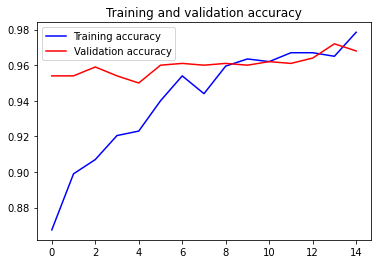

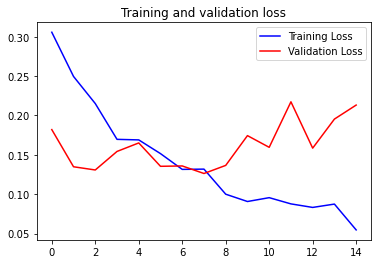

In [22]:
plot_resultult(history)

In [25]:
test_loss, test_acc = model.evaluate_generator(test_generator)

print(f'Fundion de conste: {test_loss}')

print(f'Precision: {test_acc}')

/home/vic/miniconda3/envs/neural/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Fundion de conste: 0.3382088243961334
Precision: 0.9679999947547913
